### HW3, Jordan Gittleman

In [159]:
import os
import cv2
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import math
import gtsam
import gtsam.utils.plot


In [160]:
siftPts = namedtuple('siftPts', 'k d')
def siftDC(img):
    img=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    # take in source and destinatition photos and outputs sift detected key points and computed descriptors as an array
    sift = cv2.SIFT_create(nfeatures=4000,
                                   nOctaveLayers=12,
                                   contrastThreshold=0.025,
                                   sigma=1.5) #create our detector
    keypoints, descriptors = sift.detectAndCompute(img,None) # detect keypoints and compute descriptors

    return siftPts(keypoints,descriptors)

In [161]:
orbPts = namedtuple('orbPts', 'k d')
def orbDC(img):
    img=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    # take in source and destinatition photos and outputs sift detected key points and computed descriptors as an array
    orb = cv2.ORB_create() #create our detector
    keypoints, descriptors = orb.detectAndCompute(img,None) # detect keypoints and compute descriptors

    return orbPts(keypoints,descriptors)

In [162]:
def matchMaker(d1,d2,pts):
    # takes in keypoints and descriptors for two images and returns a sorted index of matches using bfmatcher
    # bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # matches = bf.match(d1,d2)
    # matches = sorted(matches, key = lambda x:x.distance)

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(d1,d2, k=2)
    

    # Apply ratio test
    good = []
    goodmatch = 0
    ratio = 0.1
    while goodmatch <= pts:
        for m in matches:
            if m[0].distance < ratio*m[1].distance:
                good.append(m[0])
                goodmatch +=1
        ratio += .1

    good = sorted(good, key = lambda x:x.distance)

    return matches, good

In [163]:
def getH(dest_kp, src_kp,matches,good): # fortunately, I do SVD in part 2a so we just need to import that code
    #and modify for use with keypoints

    dest = np.array([dest_kp[mat.queryIdx].pt for mat in good])
    src = np.array([src_kp[mat.trainIdx].pt for mat in good])
    p = np.array([0,0,0,0,0,0,0,0,1])    

    for i in range(len(dest)):
        pi = np.array([[-src[i][0],-src[i][1],-1,0,0,0,src[i][0]*dest[i][0],src[i][1]*dest[i][0],dest[i][0]],
        [0,0,0,-src[i][0],-src[i][1],-1,src[i][0]*dest[i][1],src[i][1]*dest[i][1],dest[i][1]]])
        p = np.vstack((pi,p))

  
    x = np.zeros((len(dest)*2,1))
    x = np.vstack((x,np.array([1])))
    H, residuals, rank, s = np.linalg.lstsq(p,x)
    H = H.reshape((3,3))
    

    return H



In [164]:
# try with RANSAC

def getHRANSAC(dest_kp, src_kp,matches,good): # fortunately, I do SVD in part 2a so we just need to import that code
    #and modify for use with keypoints

    dest = np.array([dest_kp[mat.queryIdx].pt for mat in good])
    src = np.array([src_kp[mat.trainIdx].pt for mat in good])
    p = np.array([0,0,0,0,0,0,0,0,1])    

    # H, mask=cv2.findHomography(src, dest, cv2.RANSAC,confidence=0.997)
    H=cv2.estimateAffinePartial2D(src,dest) # modification to do a rigid transformation, we can only make this assumption due to the planar nature of this data
    H=H[0]
    scale = math.sqrt(H[0,0]**2 + H[0,1]**2)
    H[0,:] /=scale
    H[1,:] /=scale
    H=np.vstack((H,[0,0,1]))
    # print(H)
    
    # print(H)
    return H


In [165]:
def shifter(img,dest,H):
# caculate translational homography to shift images by to keep everything in the positive axis of our eventual image
    h1,w1 = img.shape[:2] #grab height and width from input image
    h2,w2 = dest.shape[:2] #grab height and width from dest image
    pts = ([0,0],[0,h1],[w1,h1],[w1,0]) #create an array of just the corners in order top left, top right, bottom left, bottom right
    transPts=[]
    for pt in pts:
        # print(np.array([pt.x,pt.y]))
        transPts.append(np.matmul(H,np.array([pt[0],pt[1],1]))) #matmul the corners by the homography
    #this little x_min/max section was inspired by the great Xavier Hubbard 
    x_min = min(pt[0]/pt[2] for pt in transPts)
    x_max = max(pt[0]/pt[2] for pt in transPts) #find minimum and maximum values for x of corners. I dont really care about y since I think keeping overal y dimension constant will look nicer.

    if x_min <0:
        x_shift = abs(x_min)
        # dim = (int(x_max+x_shift+w2),h1)

    elif x_min >0:
        x_shift = 0
        # dim = (int(x_max+x_shift+w1),h1)

    #lets create our new translation homography woo!

    transH = np.array([[1,0,np.ceil(x_shift)],[0,1,0],[0,0,1]])
    return transH

In [166]:
def sticher(warps: list,dim):
    dest = warps[0]
    for ind in range(1,len(warps)):
        out_mask=np.any(warps[ind],2)
        out_mask=np.repeat(out_mask[:,:,np.newaxis], 3, axis=2)
        out_dest_mask=np.any(dest,2)
        out_dest_mask=np.repeat(out_dest_mask[:,:,np.newaxis], 3, axis=2)
        mask_result=np.bitwise_and(out_mask,out_dest_mask).astype("uint8")
        
        
        result = cv2.addWeighted(warps[ind], 0.5, dest, 0.5, 0)#create our blend

        mask_result=(cv2.cvtColor(mask_result, cv2.COLOR_BGR2GRAY))

        output=cv2.bitwise_and(result,result,mask=mask_result)
        result=cv2.subtract(result,output)
        result=cv2.add(result,result)
        dest = cv2.add(output, result)


    return dest
    

In [167]:
Point = namedtuple('Point', 'x y')
def dimFind(Panorama: dict):
    transPts=[]
    for part in Panorama["panopart"]:
        img1=part["img"]
        H1=part["H"]
        h1,w1 = img1.shape[:2] #grab height and width from input image
        pts1 = (Point(0,0),Point(0,h1),Point(w1,h1),Point(w1,0)) #create an array of just the corners in order top left, top right, bottom left, bottom right
    
        for pt in pts1:

            transPts.append(np.matmul(H1,np.array([pt[0],pt[1],1]))) #matmul the corners by the homography

    #this little x_min/max section was inspired by the great Xavier Hubbard 
    x_min = min(pt[0]/pt[2] for pt in transPts)
    x_max = max(pt[0]/pt[2] for pt in transPts)
    #doing the same for y, I think it makes the pano look worse though...
    y_min = min(pt[1]/pt[2] for pt in transPts)
    y_max = max(pt[1]/pt[2] for pt in transPts)
    

    if x_min <0:
        x_shift = abs(x_min)

    elif x_min >0:
        x_shift = 0

    else:
        x_shift=0
    
    if y_min <0:
        y_shift = abs(y_min)

    elif y_min >0:
        y_shift = 0
    else:
        y_shift=0

    transH = np.array([[1,0,np.ceil(x_shift)],[0,1,np.ceil(y_shift/2)],[0,0,1]])
    dim = (int(x_max+x_shift),int(y_max+y_shift))
    return dim, transH

In [168]:
def warper(Panorama: dict):
    warps=[]
    for panopart in Panorama["panopart"]:
        warps.append(cv2.warpPerspective(panopart["img"],panopart["H"],Panorama["canvas"],flags=cv2.INTER_NEAREST))
    
    return warps

    

In [169]:
def mainfunc(image_paths,RANSAC=True,sift=True,matchpts=50):
    # iterates through image pairs and finds homographies, storing them in the main panorama dict object
    Panorama = {"panopart":[]}
    H = np.eye(3)
    for image in image_paths:
        img = cv2.imread(image)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (0,0), fx=1, fy=1)
        Panorama["panopart"].append({"img":img,"H":H})
    # next, lets use our existing feature detector to calculate homographies for each image as well as shift the entire set for -x shifts 
    # as well as relating all secondary neighbors of our central image back to the center image (composite homographies)
    middle = int(len(Panorama["panopart"])/2)
    end = int(len(Panorama["panopart"])-1)
    # for ind in range(middle,0,-1): #iterating one direction (doesnt matter which)
    for ind in range(0,end): #iterating one direction (doesnt matter which)
        im1=Panorama["panopart"][ind]["img"]
        im2=Panorama["panopart"][ind+1]["img"]
        if sift:
            im1fts=siftDC(im1)
            im2fts=siftDC(im2)
        else:
            im1fts=orbDC(im1)
            im2fts=orbDC(im2)
        (match12,good)=matchMaker(im1fts.d,im2fts.d,matchpts)
        if RANSAC:
            Hr = getHRANSAC(im1fts.k,im2fts.k,match12,good)
        else:
            Hr = getH(im1fts.k,im2fts.k,match12,good)
        Panorama["panopart"][ind+1]["H"] = np.matmul(Panorama["panopart"][ind]["H"],Hr) #compositing homography back to the previous one, done iteratively this creates a chain that puts an arbitrary amount of neighbors back to the center image

    Panorama['canvas'],transH = dimFind(Panorama) #get the final dimension of our output window as well as the translation needed to put all images onto the positive quadrent
    for panopart in Panorama["panopart"]: #
        panopart["H"] = np.matmul(transH,panopart["H"]) #apply transaltion to all homographies
    warps = warper(Panorama) #warp the images
    panoFinal=sticher(warps,Panorama["canvas"]) #blend images together
    return panoFinal

That worked super well! now lets try with some harder images...

Nice. this is a pretty great success! lets also see what these look like with/without RANSAC for both SIFT and ORB

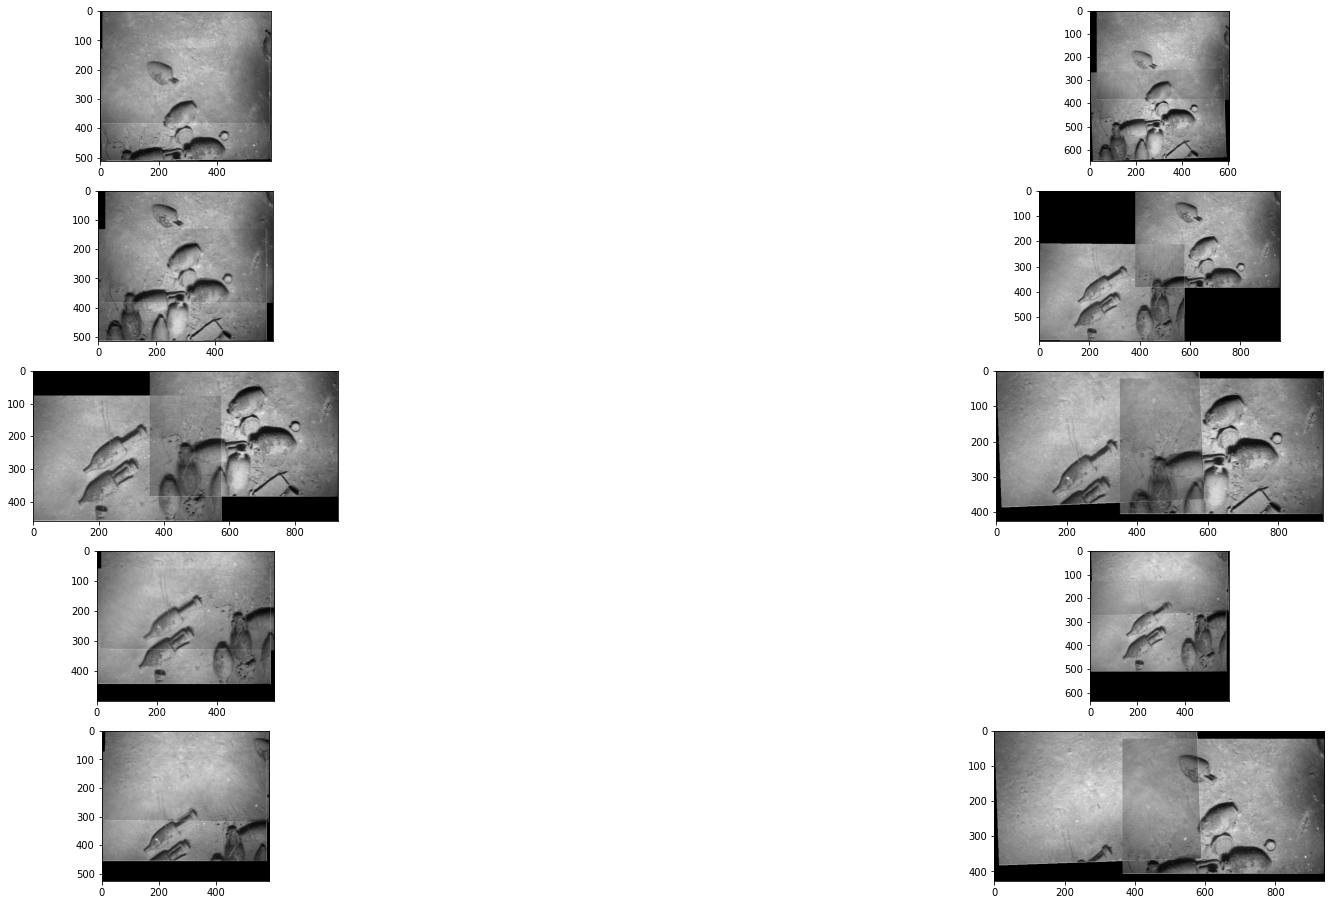

In [170]:
# image_paths=['6images/1.tif','6images/2.tif','6images/3.tif','6images/4.tif','6images/5.tif','6images/6.tif']
p1=['6Images/1.tif','6Images/2.tif']
p2=['6Images/2.tif','6Images/3.tif']
p3=['6Images/3.tif','6Images/4.tif']
p4=['6Images/4.tif','6Images/5.tif']
p5=['6Images/5.tif','6Images/6.tif']
p6=['6Images/1.tif','6Images/3.tif']
p7=['6Images/2.tif','6Images/4.tif']
p8=['6Images/3.tif','6Images/5.tif']
p9=['6Images/4.tif','6Images/6.tif']
p10=['6Images/2.tif','6Images/6.tif']
p11=['6Images/1.tif','6Images/2.tif','6Images/3.tif','6Images/4.tif','6Images/5.tif','6Images/6.tif']

figure, ax = plt.subplots(5, 2, figsize=(32, 16))
pts=2000
ax[0,0].imshow(mainfunc(p1,matchpts=pts))
ax[0,1].imshow(mainfunc(p6,matchpts=pts))
ax[1,0].imshow(mainfunc(p2,matchpts=pts))
ax[1,1].imshow(mainfunc(p7,matchpts=pts))
ax[2,0].imshow(mainfunc(p3,matchpts=pts))
ax[2,1].imshow(mainfunc(p8,matchpts=pts))
ax[3,0].imshow(mainfunc(p4,matchpts=pts))
ax[3,1].imshow(mainfunc(p9,matchpts=pts))
ax[4,0].imshow(mainfunc(p5,matchpts=pts))
ax[4,1].imshow(mainfunc(p10,matchpts=pts))

# ax[3].imshow(mainfunc(image_paths,matchpts=150))
# ax[4].imshow(mainfunc(image_paths,sift=False,matchpts=150)) 

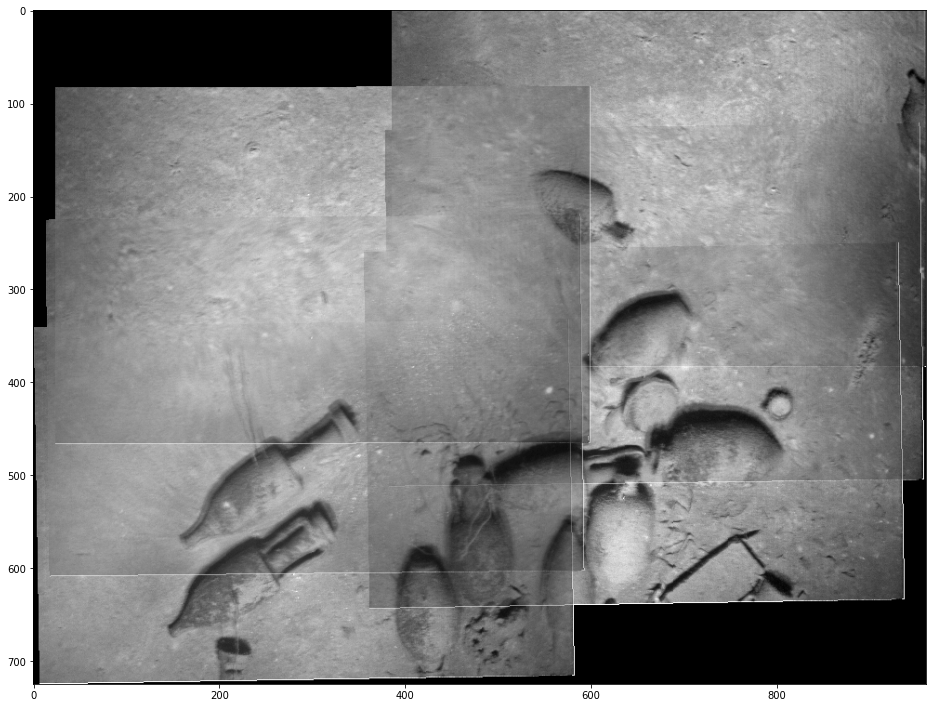

In [171]:
plt.figure(figsize=(16,16))
plt.imshow(mainfunc(p11,matchpts=pts))

Using a combo of sift + CLAHE yeilds some good stitches even with less overlap images...

Part 2. Go around the entire loop of 6 images and set up the problem by outputting vertices and edges in terms of a factor graph. Images that you manage to register in part (b) above can be thought of as loop closure events. 

Justify your choice of the covariance (and thus information) matrix that you use for each edge. Once you have completed the loop run a GTSAM script on the output vertices and edges and see how that 
(a) Affects the location of individual image centers - your "odometry" (make a plot before and after optimization)
(b) Plot the covariances for each measurement before and after optimization

To start thinking of this problem as a factor graph, we need to set some basic asumptions in the construction of our graph.

the following code is heavily inspired by ZZ

In [172]:
# Lets start by making a function to load in our images and detect features, storing what we find for later
Graphbin = namedtuple('Graphbin', 'im pts')
def gtloader(folder):
    im_paths = []
    for file in os.listdir(folder):
        if ".tif" in file:
            im_paths.append(os.path.join(folder,file))
            # print(im_paths)

    # now lets find features for each image and put them in a list
    imgsAndPts=[]

    for image in im_paths:
        img = cv2.imread(image)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (0,0), fx=1, fy=1)
        imgsAndPts.append(Graphbin(img,siftDC(img)))

    # im_height, im_width = ims[0].shape[:2]
    # # get center point of image, this is our "pose"
    # cam_matrix = np.array([[1, 0, im_width/2], 
    #                       [0, 1, im_height/2],
    #                       [0, 0, 1]])

    return imgsAndPts
    
    

In [217]:
# finding matches and noise
def noisyMatch(pts1,pts2,pts=300):
    raw,good = matchMaker(pts1.d,pts2.d,pts)
    # if len(good) < 6:
    #     return 0, 0
    H = getHRANSAC(pts1.k,pts2.k,raw,good)
    
    diag_noise = 1000*len(good)**-2*np.array([1, 1, np.deg2rad(1)])

    gtsam_noise = gtsam.noiseModel.Diagonal.Sigmas(diag_noise)

    return H, gtsam_noise

In [218]:
# with this, we also need to introduce some noise to create a covarience. 
# For this, we will implement a basic diagonal noise model
# prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([10, 10, np.deg2rad(10)])) # diagonal noise model, 10 is arbitrary


# initial = gtsam.Values() # add empty prior

In [219]:
# def gtmatch(srcInd,dstInd,match_dict):
#     if match_dict[srcInd][dstInd]:
#         return match_dict[srcInd][dstInd]

#     else:
#         
        

In [220]:
def get_gtsam_pose2(affine_matrix):
    return gtsam.Pose2(affine_matrix[0, -1], affine_matrix[1, -1],
                       np.arctan2(affine_matrix[1, 0], affine_matrix[0, 0]))

In [221]:
def gtinit(imgsAndPts: Graphbin,initial):
    total_affine_matrix = np.eye(3)

    initial.insert(0, gtsam.Pose2())

    for srcInd in range(len(imgsAndPts)-1):

        dstInd = srcInd + 1

        affine_matrix, gtsam_noise = noisyMatch(imgsAndPts[srcInd].pts, imgsAndPts[dstInd].pts)

        total_affine_matrix = affine_matrix.dot(total_affine_matrix)

        initial.insert(dstInd, get_gtsam_pose2(total_affine_matrix))

    return total_affine_matrix, initial

In [222]:
def gtbuild(folder):
    imgsAndPts = gtloader(folder)

    prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([10, 10, np.deg2rad(10)])) # diagonal noise model, 10 is arbitrary
    initial = gtsam.Values()

    graph = gtsam.NonlinearFactorGraph()
    im_height, im_width = (imgsAndPts[0].im).shape[:2]
    # get center point of image, this is our "pose"
    cam_matrix = np.array([[1, 0, im_width/2], 
                          [0, 1, im_height/2],
                          [0, 0, 1]])

    graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(
        im_width/2, im_height/2, 0), prior_noise))


    total_affine_matrix, initial = gtinit(imgsAndPts,initial)

    for srcInd in range(0,len(imgsAndPts)-2):
        for dstInd in range(1,len(imgsAndPts)-1):

            if srcInd + 1 == dstInd:# of the images air neighbors, we assume match

                affine_matrix, gtsam_noise = noisyMatch(imgsAndPts[srcInd].pts, imgsAndPts[dstInd].pts)

                total_affine_matrix = affine_matrix.dot(total_affine_matrix)

                graph.add(gtsam.BetweenFactorPose2(srcInd, dstInd, #add homography + noise as pose between two points
                                                get_gtsam_pose2(affine_matrix), gtsam_noise))

            elif cv2.norm(initial.atPose2(srcInd).translation()-initial.atPose2(dstInd).translation()) < im_width:
                affine_matrix, gtsam_noise = noisyMatch(imgsAndPts[srcInd].pts, imgsAndPts[dstInd].pts)
                # if len(affine_matrix) == False:
                #     break

                total_affine_matrix = affine_matrix.dot(total_affine_matrix)

                graph.add(gtsam.BetweenFactorPose2(srcInd, dstInd, #add homography + noise as pose between two points
                                                get_gtsam_pose2(affine_matrix), gtsam_noise))

    return graph, initial, imgsAndPts

In [223]:
def plot_graph(values, graph, marginals):

    for vertex_index in range(values.size()-1):
        gtsam.utils.plot.plot_pose2(0, values.atPose2(
            vertex_index), 0.5, marginals.marginalCovariance(vertex_index))

    for edge_index in range(graph.size())[1:]:
        key1, key2 = graph.at(edge_index).keys()

        start_pose = values.atPose2(key1)
        end_pose = values.atPose2(key2)
        plt.plot([start_pose.x(), end_pose.x()],
                 [start_pose.y(), end_pose.y()],
                 color='blue')

    plt.show()

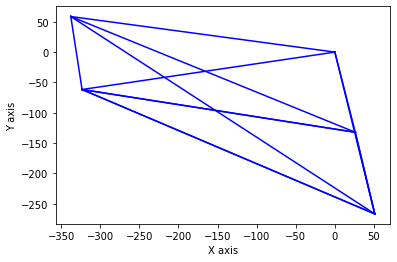

In [224]:
graph, initial, imgsAndPts = gtbuild("./6Images")
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

In [ ]:
def gtimshow():
    # iterates through image pairs and finds homographies, storing them in the main panorama dict object
    Panorama = {"panopart":[]}
    H = np.eye(3)
    for image in image_paths:
        img = cv2.imread(image)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (0,0), fx=1, fy=1)
        Panorama["panopart"].append({"img":img,"H":H})
    # next, lets use our existing feature detector to calculate homographies for each image as well as shift the entire set for -x shifts 
    # as well as relating all secondary neighbors of our central image back to the center image (composite homographies)
    middle = int(len(Panorama["panopart"])/2)
    end = int(len(Panorama["panopart"])-1)
    # for ind in range(middle,0,-1): #iterating one direction (doesnt matter which)
    for ind in range(0,end): #iterating one direction (doesnt matter which)
        im1=Panorama["panopart"][ind]["img"]
        im2=Panorama["panopart"][ind+1]["img"]
        if sift:
            im1fts=siftDC(im1)
            im2fts=siftDC(im2)
        else:
            im1fts=orbDC(im1)
            im2fts=orbDC(im2)
        (match12,good)=matchMaker(im1fts.d,im2fts.d,matchpts)
        if RANSAC:
            Hr = getHRANSAC(im1fts.k,im2fts.k,match12,good)
        else:
            Hr = getH(im1fts.k,im2fts.k,match12,good)
        Panorama["panopart"][ind+1]["H"] = np.matmul(Panorama["panopart"][ind]["H"],Hr) #compositing homography back to the previous one, done iteratively this creates a chain that puts an arbitrary amount of neighbors back to the center image

    Panorama['canvas'],transH = dimFind(Panorama) #get the final dimension of our output window as well as the translation needed to put all images onto the positive quadrent
    for panopart in Panorama["panopart"]: #
        panopart["H"] = np.matmul(transH,panopart["H"]) #apply transaltion to all homographies
    warps = warper(Panorama) #warp the images
    panoFinal=sticher(warps,Panorama["canvas"]) #blend images together
    return panoFinal